## Obtain heat flux through mixed layer time series for Ross Sea

In [1]:
%load_ext autoreload

import warnings 
warnings.filterwarnings("ignore")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import dask
import intake 

from distributed import Client
from ncar_jobqueue import NCARCluster
from dask_jobqueue import PBSCluster

In [2]:
# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='50 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=2:mem=50GB', # Specify resources
    project='NCGD0011', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.20:41184,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Historical

#### Get data for septembers only

In [3]:
def preprocess(ds):
    ds=ds.isel(z_t=slice(0,40), z_w_bot=slice(0,40)).sel(time=ds.time.dt.month.isin([9]))
    return ds

In [4]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json')

catalog.df.experiment.unique()

CPU times: user 29.4 s, sys: 2.04 s, total: 31.4 s
Wall time: 34.2 s


array(['historical', 'ssp370'], dtype=object)

In [5]:
%%time
var = ['HMXL','DIA_IMPVF_TEMP']
# get the historical
subset_hist = catalog.search(component='ocn',
                        variable=var,
                        experiment='historical',
                        forcing_variant='cmip6')

CPU times: user 1.23 s, sys: 3.18 ms, total: 1.23 s
Wall time: 1.29 s


In [6]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_mix = subset_hist.to_dataset_dict(preprocess=preprocess)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 47 s, sys: 1.47 s, total: 48.4 s
Wall time: 1min 37s


In [7]:
%%time
# here we join the two variables into one dataset 
my_key_mix = 'ocn.historical.pop.h.cmip6.' + var[0]
ds_tmp_mix = dsets_mix[my_key_mix]

my_key_mix = 'ocn.historical.pop.h.cmip6.' + var[1]
ds_hist_mix = dsets_mix[my_key_mix]

ds_hist_mix = xr.merge([ds_hist_mix,ds_tmp_mix])

#fix time dimension so it's a mean of the timebounds
ds_hist_mix['time']= ds_hist_mix.time_bound.compute().mean(dim="d2")

CPU times: user 1.35 s, sys: 90.3 ms, total: 1.44 s
Wall time: 4.95 s


In [8]:
keep_vars = ['z_t', 'z_w_bot','z_t_150m','time_bound','dz','TLAT','TLONG','time', 'REGION_MASK', 'hflux_factor', 'TAREA'] + var
ds_hist_mix = ds_hist_mix.drop([v for v in ds_hist_mix.variables if v not in keep_vars])

#### Get only Ross Sea 

In [9]:
%%time
# mask outside Ross Sector present day 
ds_rs_hist_mix_sep = ds_hist_mix.where((ds_hist_mix.TLONG > 160) & (ds_hist_mix.TLONG.values < 210) & (ds_hist_mix.TLAT < -72),
                     drop=True).load()

CPU times: user 1min 27s, sys: 5.13 s, total: 1min 32s
Wall time: 20min 23s


In [10]:
print('ds:', ds_rs_hist_mix_sep.dims, 'hmxl:' , ds_rs_hist_mix_sep.HMXL.dims, 'mix:' , ds_rs_hist_mix_sep.DIA_IMPVF_TEMP.dims)

ds: Frozen({'z_t': 40, 'nlat': 14, 'nlon': 44, 'time': 165, 'd2': 2, 'member_id': 50, 'z_w_bot': 40, 'z_t_150m': 15}) hmxl: ('member_id', 'time', 'nlat', 'nlon') mix: ('member_id', 'time', 'z_w_bot', 'nlat', 'nlon')


### Get the heat flux through the mixed layer for the entire september timeseries

In [11]:
jq_through_hmxl_hist_sep = ds_rs_hist_mix_sep.DIA_IMPVF_TEMP.sel(z_w_bot=ds_rs_hist_mix_sep.HMXL, method='nearest')

#### This worked, now checking what it looks like

In [12]:
(jq_through_hmxl_hist_sep.sel(time=slice('1980', '1989')).mean(dim=['member_id','time'])/ds_ssp.hflux_factor).plot(robust=True)

NameError: name 'ds_ssp' is not defined

NameError: name 'ds_ssp' is not defined

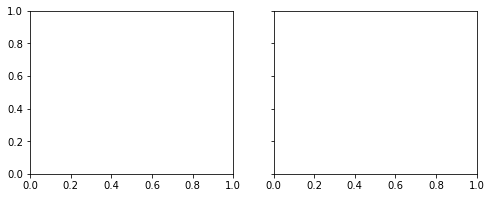

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

cdat = ax[0].contourf(jq_through_hmxl_hist_sep.TLONG, jq_through_hmxl_hist_sep.TLAT, 
                      (jq_through_hmxl_hist_sep.sel(time=slice('1980', '1989')).mean(dim=['member_id','time'])/ds_ssp.hflux_factor),
                     levels=np.arange(-200,20,20), cmap='Blues', extend='both')
# ax[1].contourf(ds_2070.TLONG, ds_2070.TLAT, (ds_2070.HFL_HMXL_2070s),
#                      levels=np.arange(-200,20,20), cmap='Blues')

ax[0].set_title('1980s')
ax[1].set_title('2070s')
plt.colorbar(cdat, ax=ax[:2])

# cdat = ax[0].contour(ds_1980.TLONG, ds_1980.TLAT, ds_1980.HMXL_1980s,
#                      levels=np.arange(0,220,20), colors='black')
# ax[1].contour(ds_2070.TLONG, ds_2070.TLAT, (ds_2070.HMXL_2070s),
#                      levels=np.arange(0,220,20), colors='black')


#### Saving the data for Alice

In [ ]:
# make sure you save the heat flux in W/m2 and save the HMXL along with it in m 
ds_hist_derived = (jq_through_hmxl_hist_sep/ds_ssp.hflux_factor).to_dataset(name='HFL_HMXL_hist')#.nbytes/1e9
ds_hist_derived['HMXL_hist'] = ds_rs_hist_mix_sep.HMXL/100

ds_hist_derived['HFL_HMXL_hist'].attrs = {"units": 'W/m2'}
ds_hist_derived['HMXL_hist'].attrs = {"units": 'm'}

In [ ]:
ds_hist_derived.to_netcdf('hist_HMXL_HFLX_ensmembers_timeseries_RossSea.nc')

### Future

In [14]:
subset_fut = catalog.search(component='ocn',
                        variable=var,
                        experiment='ssp370',
                        forcing_variant='cmip6',
                       )

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset_fut.to_dataset_dict(preprocess=preprocess)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


In [15]:
%%time
# merge the two datasets again 
my_key = 'ocn.ssp370.pop.h.cmip6.' + var[0]
ds_tmp = dsets[my_key]

my_key = 'ocn.ssp370.pop.h.cmip6.' + var[1]
ds_ssp = dsets[my_key]

ds_ssp = xr.merge([ds_ssp,ds_tmp])

#fix time dimension so it's a mean of the timebounds
ds_ssp['time']= ds_ssp.time_bound.compute().mean(dim="d2")

CPU times: user 1.02 s, sys: 69.5 ms, total: 1.09 s
Wall time: 4.07 s


In [16]:
keep_vars = ['z_t', 'z_w_bot','z_t_150m','time_bound','dz','TLAT','TLONG','time', 'REGION_MASK', 'hflux_factor'] + var
ds_ssp = ds_ssp.drop([v for v in ds_ssp.variables if v not in keep_vars])

#### Get only Ross Sea 

In [17]:
%%time
# mask outside Ross Sector present day 
ds_rs_ssp_mix_sep = ds_ssp.where((ds_ssp.TLONG > 160) & (ds_ssp.TLONG.values < 210) & (ds_ssp.TLAT < -72),
                     drop=True).load()

CPU times: user 31.6 s, sys: 2.33 s, total: 33.9 s
Wall time: 10min 10s


In [18]:
print('ds:', ds_rs_ssp_mix_sep.dims, 'hmxl:' , ds_rs_ssp_mix_sep.HMXL.dims, 'mix:' , ds_rs_ssp_mix_sep.DIA_IMPVF_TEMP.dims)

ds: Frozen({'z_t': 40, 'nlat': 14, 'nlon': 44, 'time': 86, 'd2': 2, 'member_id': 50, 'z_w_bot': 40, 'z_t_150m': 15}) hmxl: ('member_id', 'time', 'nlat', 'nlon') mix: ('member_id', 'time', 'z_w_bot', 'nlat', 'nlon')


### Get the heat flux through the mixed layer for the entire september timeseries

In [ ]:
jq_through_hmxl_ssp_sep = ds_rs_ssp_mix_sep.DIA_IMPVF_TEMP.sel(z_w_bot=ds_rs_ssp_mix_sep.HMXL, method='nearest')

In [ ]:
(jq_through_hmxl_ssp_sep.sel(time=slice('2070', '2079')).mean(dim=['member_id','time'])).plot(robust=True)

#### Calculated, make sure it looks ok 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

cdat = ax[0].contourf(jq_through_hmxl_hist_sep.TLONG, jq_through_hmxl_hist_sep.TLAT, 
                      (jq_through_hmxl_hist_sep.sel(time=slice('1980', '1989')).mean(dim=['member_id','time'])/ds_ssp.hflux_factor),
                     levels=np.arange(-200,20,20), cmap='Blues', extend='both')
ax[1].contourf(jq_through_hmxl_ssp_sep.TLONG, jq_through_hmxl_ssp_sep.TLAT, 
               (jq_through_hmxl_ssp_sep.sel(time=slice('2070', '2079')).mean(dim=['member_id','time'])/ds_ssp.hflux_factor),
                     levels=np.arange(-200,20,20), cmap='Blues')

ax[0].set_title('1980s September only')
ax[1].set_title('2070s September only')
plt.colorbar(cdat, ax=ax[:2])

# cdat = ax[0].contour(ds_1980.TLONG, ds_1980.TLAT, ds_1980.HMXL_1980s,
#                      levels=np.arange(0,220,20), colors='black')
# ax[1].contour(ds_2070.TLONG, ds_2070.TLAT, (ds_2070.HMXL_2070s),
#                      levels=np.arange(0,220,20), colors='black')


#### Compare to what you had done before -- that was probably all year

In [ ]:
ds_1980 = xr.open_dataset('1980s_HMXL_HFLX.nc')
ds_2070 = xr.open_dataset('2070s_HMXL_HFLX.nc')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

cdat = ax[0].contourf(ds_1980.TLONG, ds_1980.TLAT, ds_1980.HFL_HMXL_1980s,
                     levels=np.arange(-200,20,20), cmap='Blues', extend='both')
ax[1].contourf(ds_2070.TLONG, ds_2070.TLAT, (ds_2070.HFL_HMXL_2070s),
                     levels=np.arange(-200,20,20), cmap='Blues')

ax[0].set_title('1980s all year')
ax[1].set_title('2070s all year')
plt.colorbar(cdat, ax=ax[:2])

cdat = ax[0].contour(ds_1980.TLONG, ds_1980.TLAT, ds_1980.HMXL_1980s,
                     levels=np.arange(0,220,20), colors='black')
ax[1].contour(ds_2070.TLONG, ds_2070.TLAT, (ds_2070.HMXL_2070s),
                     levels=np.arange(0,220,20), colors='black')


#### Save the data

In [ ]:
# make sure you save the heat flux in W/m2 and save the HMXL along with it in m 
ds_ssp_derived = (jq_through_hmxl_ssp_sep/ds_ssp.hflux_factor).to_dataset(name='HFL_HMXL_ssp')#.nbytes/1e9
ds_ssp_derived['HMXL_ssp'] = ds_rs_ssp_mix_sep.HMXL/100

ds_ssp_derived['HFL_HMXL_ssp'].attrs = {"units": 'W/m2'}
ds_ssp_derived['HMXL_ssp'].attrs = {"units": 'm'}

In [ ]:
ds_ssp_derived.to_netcdf('ssp_HMXL_HFLX_ensmembers_timeseries_RossSea.nc')

### Save new september only hflx through mxl files

In [ ]:
ds_sept_1980s_HFLXthroughHMXL = (jq_through_hmxl_hist_sep.sel(time=slice('1980', '1989')).mean(dim=['member_id','time'])
                                 /
                                 ds_ssp.hflux_factor).to_dataset(name='HFL_HMXL_1980s')
ds_sept_1980s_HFLXthroughHMXL['HFL_HMXL_1980s'].attrs = {"units": 'W/m2'}

ds_sept_1980s_HFLXthroughHMXL['HMXL_1980s'] = ds_rs_hist_mix_sep.HMXL.sel(time=slice('1980', '1989')).mean(dim=['member_id','time'])/100
ds_sept_1980s_HFLXthroughHMXL['HMXL_1980s'].attrs = {"units": 'm'}

ds_sept_1980s_HFLXthroughHMXL.to_netcdf('mean_HFLX_HMXL_1980s_septembers.nc')

In [ ]:
ds_sept_2070s_HFLXthroughHMXL = (jq_through_hmxl_ssp_sep.sel(time=slice('2070', '2079')).mean(dim=['member_id','time'])
                                 /
                                 ds_ssp.hflux_factor).to_dataset(name='HFL_HMXL_2070s')
ds_sept_2070s_HFLXthroughHMXL['HFL_HMXL_2070s'].attrs = {"units": 'W/m2'}

ds_sept_2070s_HFLXthroughHMXL['HMXL_2070s'] = ds_rs_ssp_mix_sep.HMXL.sel(time=slice('2070', '2079')).mean(dim=['member_id','time'])/100
ds_sept_2070s_HFLXthroughHMXL['HMXL_2070s'].attrs = {"units": 'm'}

ds_sept_2070s_HFLXthroughHMXL.to_netcdf('mean_HFLX_HMXL_2070s_septembers.nc')

### Make T and S diagrams and T and S timeseries and potential density 

In [ ]:
path = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ocn/proc/tseries/month_1/'
tarea_file = xr.open_dataset(path + 'SALT/b.e21.BSSP370smbb.f09_g17.LE2-1301.018.pop.h.SALT.204501-205412.nc')

In [ ]:
tarea_rs = tarea_file.TAREA.where((tarea_file.TLONG > 160) & (tarea_file.TLONG.values < 210) & (tarea_file.TLAT < -72),
                     drop=True).load()

In [ ]:
ds_t = xr.open_zarr('T_antarctica_ensmean_September.zarr/')
ds_s = xr.open_zarr('S_antarctica_ensmean_September.zarr/')

In [ ]:
%%time
# mask outside Ross Sector present day 
ds_t_rs =  ds_t.where((ds_t.TLONG > 160) & (ds_t.TLONG.values < 210) & (ds_t.TLAT < -72),
                     drop=True).load()

In [ ]:
%%time
# mask outside Ross Sector present day 
ds_s_rs =  ds_s.where((ds_s.TLONG > 160) & (ds_s.TLONG.values < 210) & (ds_s.TLAT < -72),
                     drop=True).load()

In [ ]:
print('hmxl', ds_rs_hist_mix_sep.HMXL.shape)

In [ ]:
print('salt', ds_s_rs.TEMP.shape, 'temp', ds_t_rs.TEMP.shape)

### Upper 600m

In [ ]:
ds_s_rs.TEMP.TLAT.isel(nlon=10).plot()
ds_rs_hist_mix_sep.HMXL.TLAT.isel(nlon=10, nlat=slice(2,14)).plot()

In [ ]:
plt.scatter(ds_s_rs.TEMP.sel(time=slice('2070','2079'), z_t=slice(0,600e2)), 
            ds_t_rs.TEMP.sel(time=slice('2070','2079'), z_t=slice(0,600e2)), 
            s=1, marker='o', label='2070s', c='orange')

plt.scatter(ds_s_rs.TEMP.sel(time=slice('1980', '1989'), z_t=slice(0,600e2)), 
            ds_t_rs.TEMP.sel(time=slice('1980', '1989'), z_t=slice(0,600e2)), 
            s=1, marker='o', label='1980s', c='blue')

# plt.scatter(ds_s_rs.TEMP.sel(time=slice('2070','2079'), z_t=slice(0,600e2)), 
#             ds_t_rs.TEMP.sel(time=slice('2070','2079'), z_t=slice(0,600e2)), 
#             s=1, marker='o', label='2070s', c='orange')

plt.legend(frameon=False)
plt.title('T and S 0-600m');
plt.ylabel(r'T [$^{\circ}$C]');
plt.xlabel(r'S [PSU]');

# Make the figure

In [ ]:
# accurate averaging: sum(TEMP*TAREA*z_t)/sum(TAREA*z_t)

In [ ]:
z_t_600m = ds_t_rs.z_t.sel(z_t=slice(0,600e2))

In [ ]:
tarea_rs.shape

In [ ]:
(tarea_rs/1000000000000).plot(robust=True)

In [ ]:
ds_t_rs.TEMP.sel(z_t=slice(0,600e2)).mean(dim=['z_t','nlat', 'nlon']).plot(label='mean')

((ds_t_rs.TEMP.sel(z_t=slice(0,600e2))*tarea_rs.isel(nlat=slice(2,14))*z_t_600m).sum(dim=['z_t','nlat', 'nlon'])
 /
 (tarea_rs.isel(nlat=slice(2,14))*z_t_600m).sum(dim=['z_t','nlat', 'nlon'])).plot(ls=':', label='weighted mean')
plt.legend()

In [ ]:
(
 ((ds_s_rs.TEMP.sel(z_t=slice(0,600e2))*z_t_600m)).sum('z_t')
 /
 (z_t_600m.sum('z_t'))
).mean('time').plot(levels=np.arange(33.4,34.9,0.1), extend='both')

In [ ]:
ds_s_rs.TEMP.sel(z_t=slice(0,600e2)).mean(dim=['z_t','nlat', 'nlon']).plot(label='mean')

((ds_s_rs.TEMP.sel(z_t=slice(0,600e2))*tarea_rs.isel(nlat=slice(2,14))*z_t_600m).sum(dim=['z_t','nlat', 'nlon'])
 /
 (tarea_rs.isel(nlat=slice(2,14))*z_t_600m).sum(dim=['z_t','nlat', 'nlon'])).plot(ls=':', label='weighted mean')
plt.legend()

In [ ]:
%%time
# plot it
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2.5, 1]}, figsize=(14,3))
t, =a0.plot(ds_t_rs.time, 
            ds_t_rsa.TEMP.sel(z_t=slice(0,600e2)).mean(dim=['z_t','nlat', 'nlon']), 
            c='blue', label='Temperature')
a0.set_ylabel(R'[$^{\circ}$C]')
a0.set_yticks(np.arange(-0.6,-0.2,.1))
asal = a0.twinx()
s, =asal.plot(ds_s_rs.time, ds_s_rs.TEMP.sel(z_t=slice(0,600e2)).mean(dim=['z_t','nlat', 'nlon']), c='green', label='Salinity')
asal.set_ylabel(R'[PSU]')
asal.set_yticks(np.arange(34.3,34.5,0.1))
plt.legend([t, s],["Temperature", "Salinity"], loc='center right', frameon=False)

a0.set_title('Ross Sea Mean 0-600m')

a1.scatter(ds_s_rs.TEMP.sel(time=slice('2070','2079'), z_t=slice(0,600e2)), 
            ds_t_rs.TEMP.sel(time=slice('2070','2079'), z_t=slice(0,600e2)), 
            s=1, marker='o', label='2070s', c='lightblue')

a1.scatter(ds_s_rs.TEMP.sel(time=slice('1980', '1989'), z_t=slice(0,600e2)), 
            ds_t_rs.TEMP.sel(time=slice('1980', '1989'), z_t=slice(0,600e2)), 
            s=1, marker='o', label='1980s', c='darkblue')

a1.legend(frameon=False)
# a1.set_title('T and S 0-600m');
a1.set_ylabel(r'T [$^{\circ}$C]');
a1.set_xlabel(r'S [PSU]');

f.tight_layout()
f.savefig('RossSea_areamean_0-600m_T_S_ts_TS_Diagram.png', dpi=300, bbox_inches='tight')

In [ ]:
ds_t_rs.TEMP.sel(time=slice('1980', '1989'), z_t=slice(0,600e2)).mean().values

In [ ]:
ds_t_rs.TEMP.sel(time=slice('2070', '2079'), z_t=slice(0,600e2)).mean().values

In [ ]:
ds_t_rs.TEMP.sel(z_t=slice(0,600e2)).mean(dim=['z_t','nlat', 'nlon']).plot()

### only in the mixed layer

In [ ]:
temp_80s = ds_t_rs.TEMP.sel(time=slice('1980', '1989')).load()
salt_80s = ds_s_rs.TEMP.sel(time=slice('1980', '1989')).load()
hmxl_80s = ds_rs_hist_mix_sep.HMXL.sel(time=slice('1980', '1989'), nlat=slice(2,14)).mean('member_id').load()

In [ ]:
hmxl_80s.mean().values/100

In [ ]:
hmxl_70s.mean().values/100

In [ ]:
temp_70s = ds_t_rs.TEMP.sel(time=slice('2070', '2079')).load()
salt_70s = ds_s_rs.TEMP.sel(time=slice('2070', '2079')).load()
hmxl_70s = ds_rs_ssp_mix_sep.HMXL.sel(time=slice('2070', '2079'), nlat=slice(2,14)).mean('member_id').load()

In [ ]:
z_t_80s = temp_80s.z_t.sel(z_t=hmxl_80s, method='nearest')

In [ ]:
z_t_70s = temp_70s.z_t.sel(z_t=hmxl_70s, method='nearest')

In [ ]:
mean_mxl_70s = (hmxl_70s.mean(['time', 'nlat', 'nlon'])).values
mean_mxl_80s = (hmxl_80s.mean(['time', 'nlat', 'nlon'])).values

In [ ]:
temp_80s_in_mxl = temp_80s.sel(z_t=slice(0, mean_mxl_80s))
salt_80s_in_mxl = salt_80s.sel(z_t=slice(0, mean_mxl_80s))

In [ ]:
temp_70s_in_mxl = temp_70s.sel(z_t=slice(0, mean_mxl_70s))
salt_70s_in_mxl = salt_70s.sel(z_t=slice(0, mean_mxl_70s))

In [ ]:
plt.scatter(salt_70s_in_mxl, 
            temp_70s_in_mxl, 
            s=1, marker='o', label='2070s', c='orange')

plt.scatter(salt_80s_in_mxl, 
            temp_80s_in_mxl, 
            s=1, marker='o', label='1980s', c='blue')

plt.legend(frameon=False)
plt.title('T and S 0- Mean Mixed Layer Depth');
plt.ylabel(r'T [$^{\circ}$C]');
plt.xlabel(r'S [PSU]');

## Get Potential density to add
POP's equation of state uses time invariant pressure: 
$$p0(z) = 0.059808[exp(−0.025z) − 1] + 0.100766z + 2.28405 × 10−7z^2$$

And I don't actually know which one is used but since we really only want to put density lines on this diagram we're gonna use the most simple EOS:
$$ρ = ρ0 − 2.5 −4Θ + 7.6 × 10^{−4} S $$

In [ ]:
def p0(z):
    p = 0.059808 * (np.exp(-0.025*z)-1) + 0.100766 * z + 2.28405 * 10**(-7) * z**2
    return p

In [ ]:
p_for_this = p0(ds_hist_mix.z_t/100)

In [ ]:
temperature[10]

In [ ]:
def rho(T, S, p0=p_for_this):
    rho_0 = 1027# kg m−3
    rho = rho_0 -2.5 - 4 * T + 7.6*10**(-4) * S
    return rho

In [ ]:
for ti , t in enumerate(temperature):
    print(1027 -2.5 - 4 * t + 7.6*10**(-4) * 34.2)

In [ ]:
# this is wrong
def rho2d(T, S, p0=p_for_this):
    rho_0 = 1027# kg m−3
    rho_2darr = np.zeros([T.shape[0], S.shape[0]])
    # print(rho_2d.shape)
    for ti, t in enumerate(T):
        # print(ti)
        rho_2darr[ti,:] = (rho_0 -2.5 - 4 * t + 7.6*10**(-4) * S)
    return rho_2darr

In [ ]:
rho_test_dummy_2d = rho2d(temperature, salinity, p0(z))

In [ ]:
rho_2d = np.zeros([51, 51])
rho_2d.shape

In [ ]:
import pandas as pd

In [ ]:
temperature.shape

In [ ]:
np.random.seed(0)
temperature = np.arange(-3, 2.1, 0.1)
salinity = np.linspace(33, 35.1, len(temperature))
z = np.linspace(0, 620, len(temperature))
# time = pd.date_range("2014-09-06", periods=1)
reference_time = pd.Timestamp("2014-09-05")

da_t_dummy = xr.DataArray(
    data=temperature, name='T',
    dims=["z"],#, "time"],
    coords=dict(
        z=(["z"], z),
        # time=time,
        reference_time=reference_time,
    ),
    attrs=dict(
        description="Ocean temperature dummy",
        units="degC",
    ),
)

da_s_dummy = xr.DataArray(
    data=salinity, name='S',
    dims=["z"],#, "time"],
    coords=dict(
        z=(["z"], z),
        # time=time,
        reference_time=reference_time,
    ),
    attrs=dict(
        description="Ocean salinity dummy",
        units="PSU",
    ),
)

In [ ]:
rho_test_dummy = rho(da_t_dummy, da_s_dummy, p0(z))

In [ ]:
# I need to create a 2D field of density depending on T and S how do I get that 


In [ ]:
plt.scatter(salt_70s_in_mxl, 
            temp_70s_in_mxl, 
            s=1, marker='o', label='2070s', c='orange')

plt.scatter(salt_80s_in_mxl, 
            temp_80s_in_mxl, 
            s=1, marker='o', label='1980s', c='blue')

plt.contour()

plt.legend(frameon=False)
plt.title('T and S 0- Mean Mixed Layer Depth');
plt.ylabel(r'T [$^{\circ}$C]');
plt.xlabel(r'S [PSU]');

In [ ]:
rho_test_dummy

In [ ]:
rho_test = rho(temp_70s.isel(time=0, nlat=6, nlon=20), salt_70s.isel(time=0, nlat=6, nlon=20))

In [ ]:
that_day_pd = ds_spp_pd.PD.sel(time='2070-09').load()

In [ ]:
ds_spp_pd.PD.sel(time='2070-09').where((ds_spp_pd.TLONG > 160) & (ds_spp_pd.TLONG.values < 210) & (ds_spp_pd.TLAT < -72), drop=True)

In [ ]:
rho_test.plot()

In [ ]:
plt.plot(ds_hist_mix.z_t/100, p_for_this)

In [ ]:
%%time
var = ['PD']
# get the historical
subset_hist = catalog.search(component='ocn',
                        variable=var,
                        experiment=['historical', 'ssp370'],
                        forcing_variant='cmip6')

In [ ]:
cluster.scale(24)

In [ ]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_pd = subset_hist.to_dataset_dict(preprocess=preprocess)

In [ ]:
%%time
# here we join the two variables into one dataset 
my_key_pd = 'ocn.historical.pop.h.cmip6.PD' 
ds_tmp_pd = dsets_pd[my_key_pd]

my_key_pd = 'ocn.ssp370.pop.h.cmip6.PD'
ds_hist_pd = dsets_pd[my_key_pd]

In [ ]:
keep_vars = ['z_t', 'z_w_bot','z_t_150m','time_bound','dz','TLAT','TLONG','time', 'REGION_MASK', 'hflux_factor'] + var

ds_histor_pd = ds_tmp_pd.drop([v for v in ds_tmp_pd.variables if v not in keep_vars])
ds_spp_pd = ds_hist_pd.drop([v for v in ds_hist_pd.variables if v not in keep_vars])

In [ ]:
ds_pd = xr.concat([ds_histor_pd, ds_spp_pd], dim='time')

#fix time dimension so it's a mean of the timebounds
ds_pd['time']= ds_pd.time_bound.compute().mean(dim="d2")